## Analysis script for capital_const_plan experiments.

In [1]:
#Imports
from marketsai.economies.capital_mkts.capital_const_plan import CapitalConstPlan
import scipy.io as sio
from scipy.interpolate import RegularGridInterpolator
from marketsai.utils import encode
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sn
import csv
import json
from ray.rllib.agents.ppo import PPOTrainer
from ray.tune.registry import register_env
from ray import shutdown, init


/Users/matiascovarrubias/Library/Caches/pypoetry/virtualenvs/marketsai-reVLCGV_-py3.8/lib/python3.8/site-packages/ray/autoscaler/_private/cli_logger.py:57: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
  warnings.warn(


Instructions for updating:
non-resource variables are not supported in the long term


In [2]:

""" GLOBAL CONFIGS """
# Script Options
FOR_PUBLIC = False  # for publication
SAVE_CSV = False  # save learning CSV
PLOT_PROGRESS = True  # create plot with progress
SIMUL_PERIODS = 10000
# Input Directories
# Rl experiment
INPUT_PATH_EXPERS = "/Users/matiascovarrubias/Dropbox/RL_macro/Experiments/expINFO_native_multi_hh_cap_const_plan_run_Aug26_PPO.json"

# GDSGE policy
dir_policy_folder = (
    "/Users/matiascovarrubias/Dropbox/RL_macro/Econ_algos/capital_const_plan/Results/"
)

# Output Directories
if FOR_PUBLIC:
    OUTPUT_PATH_EXPERS = "/Users/matiascovarrubias/Dropbox/RL_macro/Experiments/"
    OUTPUT_PATH_FIGURES = "/Users/matiascovarrubias/Dropbox/RL_macro/Documents/Figures/"
else:
    OUTPUT_PATH_EXPERS = "/Users/matiascovarrubias/Dropbox/RL_macro/Experiments/ALL/"
    OUTPUT_PATH_FIGURES = (
        "/Users/matiascovarrubias/Dropbox/RL_macro/Documents/Figures/ALL/"
    )

# Plot options
sn.color_palette("Set2")
sn.set_style("ticks")  # grid styling, "dark"
# plt.figure(figure=(8, 4))
# choose between "paper", "talk" or "poster"
sn.set_context(
    "paper",
    font_scale=1.4,
)

In [3]:

""" Step 0: import experiment data """
with open(INPUT_PATH_EXPERS) as f:
    exp_data_dict = json.load(f)

# UNPACK USEFUL DATA
n_agents_list = exp_data_dict["n_agents"]
exp_names = exp_data_dict["exp_names"]
checkpoints_dirs = exp_data_dict["checkpoints"]
progress_csv_dirs = exp_data_dict["progress_csv_dirs"]
best_rewards = exp_data_dict["best_rewards"]
print(best_rewards)

# checkpoint_path = "/home/mc5851/ray_results/server_5hh_capital_const_plan_run_July21_PPO/PPO_capital_const_plan_46ca2_00006_6_2021-07-21_14-27-16/checkpoint_225/checkpoint-225"
# checkpoint_path = "/Users/matiascovarrubias/ray_results/native_multi_capital_planner_test_July17_PPO/PPO_capital_planner_3e5e9_00000_0_2021-07-18_14-01-58/checkpoint_000050/checkpoint-50"

# init ray
shutdown()
init()

[35.69402788428693, 29.091766060928343, 25.77760930493272, 22.935723052852122, 20.54597139446757]


2021-08-29 15:56:42,191	INFO services.py:1267 -- View the Ray dashboard at http://127.0.0.1:8265


{'node_ip_address': '192.168.1.202',
 'raylet_ip_address': '192.168.1.202',
 'redis_address': '192.168.1.202:56634',
 'object_store_address': '/tmp/ray/session_2021-08-29_15-56-39_387678_11413/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2021-08-29_15-56-39_387678_11413/sockets/raylet',
 'webui_url': '127.0.0.1:8265',
 'session_dir': '/tmp/ray/session_2021-08-29_15-56-39_387678_11413',
 'metrics_export_port': 59995,
 'node_id': 'a64f13aced15504534d550d1e61618eed5c3fe7bfd1ced0ccb0feaa0'}

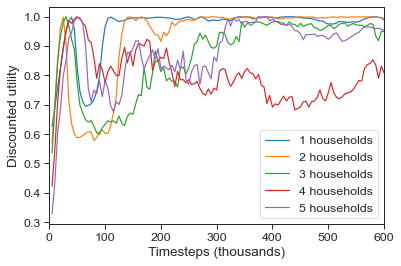

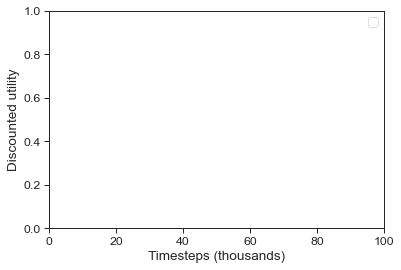

In [5]:
""" Step 1: Plot progress """

if PLOT_PROGRESS == True:
    #Big plot
    for i in range(len(exp_names)):
        data_progress_df = pd.read_csv(progress_csv_dirs[i])
        max_rewards = data_progress_df[
            "evaluation/custom_metrics/discounted_rewards_mean"
        ].max()
        data_progress_df["evaluation/custom_metrics/discounted_rewards_mean"] = (
            data_progress_df["evaluation/custom_metrics/discounted_rewards_mean"]
            / max_rewards
        )
        learning_plot_big = sn.lineplot(
            data=data_progress_df,
            y="evaluation/custom_metrics/discounted_rewards_mean",
            x="episodes_total",
        )


    learning_plot_big = learning_plot_big.get_figure()
    plt.ylabel("Discounted utility")
    plt.xlabel("Timesteps (thousands)")
    plt.xlim([0, 600])
    plt.legend(labels=[f"{i+1} households" for i in range(len(n_agents_list))])
    learning_plot_big.savefig(OUTPUT_PATH_FIGURES + "progress_BIG_" + exp_names[-1] + ".png")
    plt.show()
    plt.close()

    for i in range(len(exp_names)):
        data_progress_df = pd.read_csv(progress_csv_dirs[i])
        max_rewards = data_progress_df[
            "evaluation/custom_metrics/discounted_rewards_mean"
        ].max()
        data_progress_df["evaluation/custom_metrics/discounted_rewards_mean"] = (
            data_progress_df["evaluation/custom_metrics/discounted_rewards_mean"]
            / max_rewards
        )
        learning_plot_small = sn.lineplot(
            data=data_progress_df,
            y="evaluation/custom_metrics/discounted_rewards_mean",
            x="episodes_total",
        )


    learning_plot_small = learning_plot_small.get_figure()
    plt.ylabel("Discounted utility")
    plt.xlabel("Timesteps (thousands)")
    plt.xlim([0, 100])
    plt.legend(labels=[f"{i+1} households" for i in range(len(n_agents_list))])
    learning_plot_small.savefig(OUTPUT_PATH_FIGURES + "progress_SMALL_" + exp_names[-1] + ".png")
    plt.show()
    plt.close()

    

    #Small plot
    # for i in range(len(exp_names)):
    #     data_progress_df = pd.read_csv(progress_csv_dirs[i])
    #     max_rewards = data_progress_df[
    #         "evaluation/custom_metrics/discounted_rewards_mean"
    #     ].max()
    #     data_progress_df["evaluation/custom_metrics/discounted_rewards_mean"] = (
    #         data_progress_df["evaluation/custom_metrics/discounted_rewards_mean"]
    #         / max_rewards
    #     )
    #     learning_plot = sn.lineplot(
    #         data=data_progress_df,
    #         y="evaluation/custom_metrics/discounted_rewards_mean",
    #         x="episodes_total",
    #     )
    # learning_plot = learning_plot.get_figure()
    # plt.ylabel("Discounted utility")
    # plt.xlabel("Timesteps (thousands)")
    # plt.xlim([0, 100])
    # plt.legend(labels=[f"{i+1} households" for i in range(len(n_agents_list))])
    # learning_plot.savefig(OUTPUT_PATH_FIGURES + "progress_" + exp_names[-1] + ".png")

In [ ]:

""" Step 2: Congif and Restore RL policy and  then simulate """
y_agg_list = [[] for i in n_agents_list]
s_agg_list = [[] for i in n_agents_list]
c_agg_list = [[] for i in n_agents_list]
k_agg_list = [[] for i in n_agents_list]
shock_agg_list = [[] for i in n_agents_list]

for ind, n_hh in enumerate(n_agents_list):
    """ Step 2.0: replicate original environemnt and config """
    env_label = "capital_const_plan"
    register_env(env_label, CapitalConstPlan)
    env_horizon = 1000
    n_hh = n_hh
    n_capital = 1
    beta = 0.98
    env_config_analysis = {
        "horizon": 1000,
        "n_hh": n_hh,
        "n_capital": n_capital,
        "eval_mode": False,
        "analysis_mode": True,
        "max_savings": 0.6,
        "bgt_penalty": 1,
        "shock_idtc_values": [0.9, 1.1],
        "shock_idtc_transition": [[0.9, 0.1], [0.1, 0.9]],
        "shock_agg_values": [0.8, 1.2],
        "shock_agg_transition": [[0.95, 0.05], [0.05, 0.95]],
        "parameters": {"delta": 0.04, "alpha": 0.3, "phi": 0.5, "beta": beta},
    }

    # We instantiate the environment to extract information.
    env = CapitalConstPlan(env_config_analysis)
    config_analysis = {
        "gamma": beta,
        "env": env_label,
        "env_config": env_config_analysis,
        "horizon": env_horizon,
        "explore": False,
        "framework": "torch",
        "multiagent": {
            "policies": {
                "hh": (
                    None,
                    env.observation_space["hh_0"],
                    env.action_space["hh_0"],
                    {},
                ),
            },
            "policy_mapping_fn": (lambda agent_id: agent_id.split("_")[0]),
            "replay_mode": "independent",
        },
    }
    """ Step 2.1: restore trainer """

    # restore the trainer
    trained_trainer = PPOTrainer(env=env_label, config=config_analysis)
    trained_trainer.restore(checkpoints_dirs[ind])

    """ Step 2: Simulate an episode (MAX_steps timesteps) """
    shock_idtc_list = [[] for i in range(env.n_hh)]
    y_list = [[] for i in range(env.n_hh)]
    s_list = [[] for i in range(env.n_hh)]
    c_list = [[] for i in range(env.n_hh)]
    k_list = [[] for i in range(env.n_hh)]

    # loop
    obs = env.reset()
    for t in range(SIMUL_PERIODS):
        action = {}
        for i in range(env.n_hh):
            action[f"hh_{i}"] = trained_trainer.compute_action(
                obs[f"hh_{i}"], policy_id="hh"
            )

        obs, rew, done, info = env.step(action)
        for i in range(env.n_hh):
            shock_idtc_list[i].append(obs["hh_0"][1][i])
            y_list[i].append(info["hh_0"]["income"][i])
            s_list[i].append(info["hh_0"]["savings"][i][0])
            c_list[i].append(info["hh_0"]["consumption"][i])
            k_list[i].append(info["hh_0"]["capital"][i][0])

        # k_agg_list.append(np.sum([k_list[[j][t-1] for j in range(env_loop.n_hh)]))
        shock_agg_list[ind].append(obs["hh_0"][2])
        y_agg_list[ind].append(np.sum([y_list[i][t] for i in range(env.n_hh)]))
        s_agg_list[ind].append(
            np.sum([s_list[i][t] * y_list[i][t] for i in range(env.n_hh)])
            / y_agg_list[ind][t]
        )
        c_agg_list[ind].append(np.sum([y_list[i][t] for i in range(env.n_hh)]))
        k_agg_list[ind].append(np.sum([k_list[i][t] for i in range(env.n_hh)]))

    """ Step 2.2: Plot trajectories """

    # Idiosyncratic trajectories
    x = [i for i in range(100)]
    plt.subplot(2, 2, 1)
    for i in range(env.n_hh):
        sn.lineplot(x,shock_idtc_list[i][:100], label = f"{i} household(s)", legend=0)
    plt.title("Shock")

    plt.subplot(2, 2, 2)
    for i in range(env.n_hh):
        sn.lineplot(x,s_list[i][:100], label = f"{i} household(s)", legend=0)
    plt.title("Savings Rate")

    plt.subplot(2, 2, 3)
    for i in range(env.n_hh):
        sn.lineplot(x,y_list[i][:100], label = f"{i} household(s)", legend=0)
    plt.title("Income")

    plt.subplot(2, 2, 4)
    # plt.plot(k_agg_list[:100])
    for i in range(env.n_hh):
        sn.lineplot(x,k_list[i][:100], label = f"{i} household(s)", legend=0)
    plt.title("Capital")
    
    plt.tight_layout()
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles, labels, loc='lower right', prop={'size': 6})
    #plt.legend(labels=[f"{i+1} households" for i in range(env.n_hh)], loc='upper center', bbox_to_anchor=(0.5, 1.05))
    plt.savefig(OUTPUT_PATH_FIGURES + "SimInd_" + exp_names[ind] + ".png")
    plt.show()

    # """ Step 2.3 Run simulation on policies calculated with GDSGE """

    # dir_model = f"cap_market_{n_hh}hh_5pts"
    # matlab_struct = sio.loadmat(dir_policy_folder + dir_model, simplify_cells=True)
    # K = [
    #     np.array(matlab_struct["IterRslt"]["var_state"][f"K_{i+1}"])
    #     for i in range(n_hh)
    # ]
    # shock = np.array([i for i in range(matlab_struct["IterRslt"]["shock_num"])])
    # s_on_grid = [
    #     matlab_struct["IterRslt"]["var_policy"][f"s_{i+1}"] for i in range(n_hh)
    # ]  # type numpy.ndarray

    # s_interp = [
    #     RegularGridInterpolator((shock,) + tuple(K), s_on_grid[i]) for i in range(n_hh)
    # ]

    # sample_obs = env.observation_space.sample()
    # sample_K = obs[0]
    # sample_ind_shock = sample_obs[1]
    # sample_agg_shock = sample_obs[2]

    # #debug this and make sure that it makes sense. 
    # sample_shock_raw = [sample_agg_shock] + list(sample_ind_shock)
    # sample_shock_id = encode(sample_shock_raw, dims=[2 for i in range(n_hh + 1)])
    # pts = [sample_shock_id] + list(sample_K)
    # sample_s = [s_interp[i](pts)[0] for i in range(env.n_hh)]


    # def compute_action(obs, policy_list: list, max_action: float):
    #     # to do, check encode part
    #     K = obs[0][0]
    #     shock_raw = [obs[2], obs[1][0]]
    #     shock_id = encode(shock_raw, dims=[2 for i in range(n_hh)]) #change_dims
    #     s = [policy_list[i](np.array([shock_id] + K)) for i in range(env.n_hh)]
    #     action = np.array([2 * s[i] / max_action - 1 for i in range(env.n_hh)])
    #     return action


    # shock_list_econ = [[] for i in range(env.n_hh)]
    # s_list_econ = [[] for i in range(env.n_hh)]
    # inv_list_econ = [[] for i in range(env.n_hh)]
    # y_list_econ = [[] for i in range(env.n_hh)]
    # c_list_econ = [[] for i in range(env.n_hh)]
    # k_list_econ = [[] for i in range(env.n_hh)]
    # rew_list_econ = [[] for i in range(env.n_hh)]
    # MAX_STEPS = env.horizon
    # # MAX_STEPS = 100
    # obs = env.reset()
    # for i in range(MAX_STEPS):
    #     action = compute_action(obs, s_interp, env.max_s_per_j)
    #     obs, rew, done, info = env.step(action)
    #     # obs[1] = shock_process[i]
    #     # env.obs_[1] = shock_process[i]
    #     for i in range(env.n_hh):
    #         shock_list_econ[i].append(obs[1][i])
    #         s_list_econ[i].append(info["savings"][i][0])
    #         inv_list_econ[i].append(info["investment"][i][0])
    #         y_list_econ[i].append(info["income"][i])
    #         c_list_econ[i].append(info["consumption"][i])
    #         k_list_econ[i].append(info["capital"][i][0])
    #         rew_list_econ[i].append(info["reward"][i])


In [ ]:
shutdown()

In [ ]:
""" Step 3: Create aggregate plots"""

x = [i for i in range(100)]
plt.subplot(2, 2, 1)
for i in range(len(n_agents_list)):
    sn.lineplot(x,shock_agg_list[i][:100], label = f"{i+1} household(s)", legend=0)
plt.title("Aggregate Shock")

plt.subplot(2, 2, 2)
for i in range(len(n_agents_list)):
    sn.lineplot(x,y_agg_list[i][:100], label = f"{i+1} household(s)", legend=0)
plt.title("Aggregate Income")

plt.subplot(2, 2, 3)
for i in range(len(n_agents_list)):
    sn.lineplot(x,s_agg_list[i][:100], label = f"{i+1} household(s)", legend=0)
plt.title("Aggregate Savings Rate")

plt.subplot(2, 2, 4)
for i in range(len(n_agents_list)):
    sn.lineplot(x,k_agg_list[i][:100], label = f"{i+1} household(s)", legend=0)
plt.title("Aggregate Capital")

plt.tight_layout()
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles, labels, loc='lower right', prop={'size': 6})
plt.savefig(OUTPUT_PATH_FIGURES + "SimAgg_" + exp_names[-1] + ".png")
plt.clf
plt.show()

In [ ]:
""" Stape 4: Table with moments """

# Just give the average simulation. 
# Calculate moments of the trajectories. Which trajectory to follow?
# Create dictionary. 
# How to create a tex .txt file with the table?
# with open('mytable.tex','w') as tf:
#     tf.write(df.to_latex())

In [ ]:
""" Step 5: Compare with GDSGE policy """
# To do:
# 2. check that the structure of the interpolation is done corretly.
# 3. create return from the function.

#should I do that in the loop? probably yes!

